In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('1639345319.test_baa.pickle')

In [3]:
df['real_cnots_norm'] = df['real_cnots'] / df['real_cnots'].max()

In [4]:
df['real_cnots_norm'].describe()

count    4000.000000
mean        0.113092
std         0.215352
min         0.000000
25%         0.000000
50%         0.019608
75%         0.124183
max         1.000000
Name: real_cnots_norm, dtype: float64

<AxesSubplot:xlabel='max_fidelity_loss'>

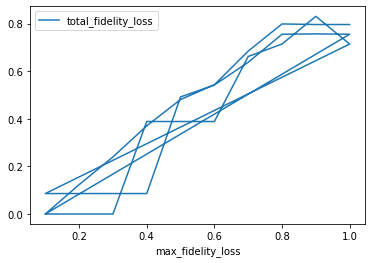

In [5]:
df[(df.id < 3) & (df.strategy == 'brute_force') & df.with_low_rank].plot('max_fidelity_loss', 'total_fidelity_loss')

<AxesSubplot:xlabel='entganglement', ylabel='real_cnots_norm'>

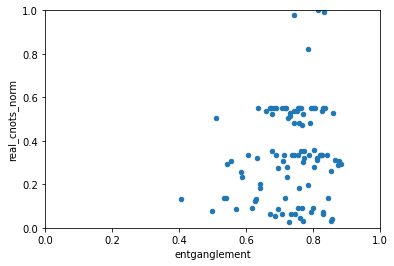

In [131]:
max_fidelity_loss = 0.1
df[(np.abs(df.max_fidelity_loss - max_fidelity_loss) < 1e-6) & (df.strategy == 'brute_force') & (df.with_low_rank)][['entganglement', 'real_cnots_norm']].plot.scatter(x=0, y=1, xlim=(0,1), ylim=(0,1))
# plt.axhline(max_fidelity_loss, color='red')

In [137]:
import tensorly as tl
from tensorly.decomposition import tucker, tensor_train, parafac, partial_tucker
from tensorly.tucker_tensor import TuckerTensor
from graph_algorithm_states import calculate_state, get_fidelity_loss, adaptive_approximation

tl.SVD_FUNS

{'numpy_svd': <bound method Backend.partial_svd of TensorLy numpy-backend>,
 'truncated_svd': <bound method Backend.truncated_svd of TensorLy numpy-backend>,
 'symeig_svd': <bound method Backend.symeig_svd of TensorLy numpy-backend>,
 'randomized_svd': <bound method Backend.randomized_svd of TensorLy numpy-backend>}

In [556]:
from test.test_baa import TestBaa

df, state_vector = TestBaa.execute_experiment(0, 4, (0.6, 0.7), np.linspace(0.2, 1.0, 2), return_state=True)

Done (0, 4, (0.6, 0.7), array([0.2, 1. ]))


In [557]:
df

,id,with_low_rank,strategy,num_qubits,depth,cnots,entganglement,entganglement (MW),max_fidelity_loss,total_saved_cnots,total_fidelity_loss,data,real_cnots,real_cnots_no_approx,real_depth,real_depth_no_approx,duration
0,0,False,brute_force,4,4,9,0.454005,0.64019,0.2,7,0.182498,"[(1, [2]), (0, [4]), (1, [2])]",1,9,5,20,0.046113
1,0,False,greedy,4,4,9,0.454005,0.64019,0.2,7,0.182498,"[(1, [2]), (0, [4]), (1, [2])]",1,9,5,20,0.051002
2,0,True,brute_force,4,4,9,0.454005,0.64019,0.2,7,0.182498,"[(1, [2]), (0, [4]), (1, [2])]",1,9,5,20,0.118000
3,0,True,greedy,4,4,9,0.454005,0.64019,0.2,5,0.014751,"[(2, [16, 1])]",6,9,17,20,0.251008
4,0,False,brute_force,4,4,9,0.454005,0.64019,1.0,9,0.406555,"[(1, [2]), (1, [2]), (1, [2]), (1, [2])]",0,9,2,20,0.041040
5,0,False,greedy,4,4,9,0.454005,0.64019,1.0,9,0.454005,"[(1, [2]), (1, [2]), (1, [2]), (1, [2])]",0,9,2,20,0.049955
6,0,True,brute_force,4,4,9,0.454005,0.64019,1.0,9,0.406555,"[(1, [2]), (1, [2]), (1, [2]), (1, [2])]",0,9,2,20,0.048003
7,0,True,greedy,4,4,9,0.454005,0.64019,1.0,9,0.454005,"[(1, [2]), (1, [2]), (1, [2]), (1, [2])]",0,9,2,20,0.040997


In [565]:
node = adaptive_approximation(state_vector, 1.0)
node, get_fidelity_loss(state_vector)

(Node((), 0.4180158392190001, 9, [array([-0.36604211-0.82069089j, -0.03167293+0.43758023j]), array([0.66540115+0.j        , 0.03019134-0.74587518j]), array([ 0.92149268+0.j       , -0.30306069+0.2429104j]), array([0.70710678+0.j        , 0.12010836+0.69683139j])]),
 0.4065559109829403)

In [728]:
permuted_state_vector = np.moveaxis(state_vector.reshape(2, 2, 2, 2), 1, 3).reshape(16,)
tensor = tl.tensor(permuted_state_vector).reshape(2, 2, 2, 2)
decomp_tensor: TuckerTensor = tucker(tensor, rank=[1, 1, 1, 1], verbose=False, svd='numpy_svd', init='random')  # truncated_svd

vec = decomp_tensor.to_vec() / np.linalg.norm(decomp_tensor.to_vec())
fidelity = np.abs(np.vdot(vec.reshape(-1, ), permuted_state_vector))**2
1 - fidelity, 1 - np.linalg.norm(decomp_tensor.core)**2

(0.40507923482506636, 0.4050792348250658)

In [ ]:
c = np.linalg.norm(decomp_tensor.to_vec())
a0 = np.abs(decomp_tensor.core[0, 0, 0]/c)**2 + np.abs(decomp_tensor.core[0, 1, 0]/c)**2
a1 = np.abs(decomp_tensor.core[1, 0, 0]/c)**2 + np.abs(decomp_tensor.core[1, 1, 0]/c)**2
a0 + a1

We begin the Tucker decomposition now

In [305]:
tensor = tl.tensor(state_vector).reshape(2,2,2,2)
decomp_tensor = tucker(tensor, rank=[1, 1, 1, 1], verbose=False, svd='truncated_svd', init='random')

In [306]:
# Our own routine just calculates the factors together by the kronecker product.
vec = calculate_state(decomp_tensor.factors)
print(np.linalg.norm(vec))

# However, if we use the function `to_vec` the core tensor is part of it of course. dividing by the core tensor (a complex value)
# we have the same norm. We will use this going forward
vec = decomp_tensor.to_vec()
print(np.linalg.norm(vec/decomp_tensor.core))

# The reduced state is thus:
vec = vec/decomp_tensor.core

1.0000000000000002
1.0000000000000002


In [307]:
# The fidelity of the resulting vector `vec` is now just the same as the squared absolute value of the core tensor

fidelity = np.abs(np.vdot(vec.reshape(-1, ), state_vector))**2
lam = decomp_tensor.core.item()

np.abs(lam)**2, fidelity

(0.37235725491807276, 0.37235725491807276)

In [308]:
# Thus we have the fidelity loss of
baa_total_fidelity_loss = df[df.with_low_rank & (df.strategy == 'brute_force') & (df.max_fidelity_loss == 1.0)].total_fidelity_loss.item()
tucker_fidelity_loss = 1 - np.abs(lam)**2,
tucker_fidelity_loss, baa_total_fidelity_loss

((0.6276427450819273,), 0.6266092061452027)

In [299]:
# Of course, without the truncation, we have a fidelity of 1
org_fidelity = np.abs(np.vdot(state_vector, state_vector))
org_fidelity

1.0000000000000004

Thus we find that the Tucker decomposition (using Higher Order Orthogonal Iteration (HOI)) we find that our method does not always find the best fidelity loss.
We will need to check if this is a problem of the code.